In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime

In [2]:
DATA_ROOT = '../data/MELBOURNE CITY/1007110000-1014110000/raw'

In [3]:
df_2727 = pd.read_csv(os.path.join(DATA_ROOT, '2727.csv'))

In [4]:
df_2727

,ID,TRAVEL_TIME,DENSITY,TIMESTAMP
0,2727,364,759,1633564800
1,2727,364,789,1633564830
2,2727,364,819,1633564860
3,2727,364,849,1633564890
4,2727,364,879,1633564920
...,...,...,...,...
20155,2727,383,285,1634169450
20156,2727,383,315,1634169480
20157,2727,383,345,1634169510
20158,2727,383,375,1634169540


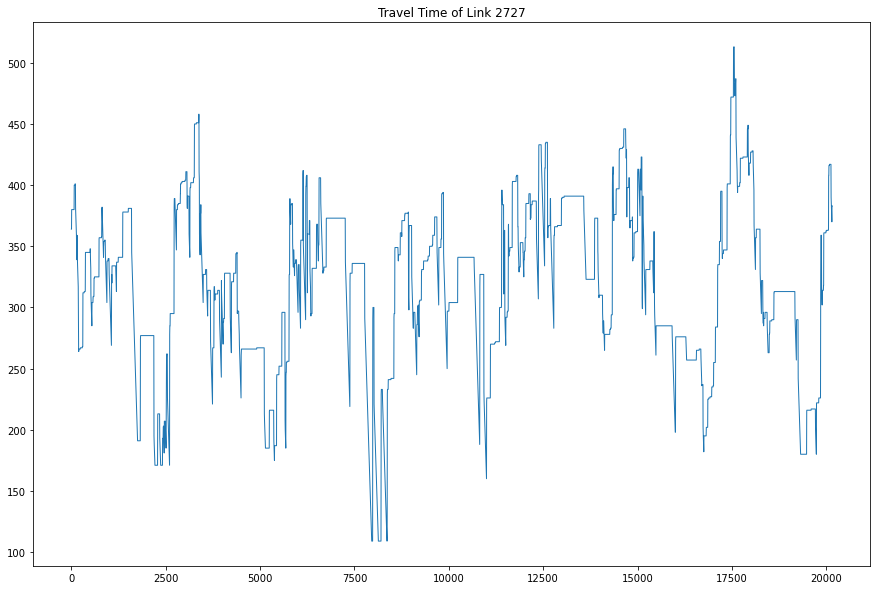

In [5]:
plt.figure(figsize=(15, 10))
plt.title('Travel Time of Link 2727')
plt.plot(list(range(len(df_2727))), df_2727['TRAVEL_TIME'].values, linewidth=1)

In [6]:
def period_of_day(timestamp):
    timestamp /= 1000
    hour = datetime.fromtimestamp(timestamp).hour
    return hour

In [7]:
raw_data_df = {}
for file_name in os.listdir(DATA_ROOT):
    raw_data_df[int(file_name[:-4])] = pd.read_csv(os.path.join(DATA_ROOT, file_name))

for link_id in raw_data_df.keys():
    raw_data_df[link_id]['TIME'] = pd.to_datetime(raw_data_df[link_id]['TIMESTAMP'], 
                                                  unit='s').dt.tz_localize('UTC').dt.tz_convert('Australia/Sydney')
    raw_data_df[link_id]['HOUR'] = raw_data_df[link_id]['TIME'].dt.hour
    raw_data_df[link_id]['DAYSOFWEEK'] = raw_data_df[link_id]['TIME'].dt.dayofweek
    raw_data_df[link_id]['WEEKDAY'] = 1
    raw_data_df[link_id].loc[raw_data_df[link_id]['DAYSOFWEEK'].isin([0, 6]), 'WEEKDAY'] = 0
    
    # Normalize Travel Time
#     max_tt = raw_data_df[link_id]['TRAVEL_TIME'].max()
#     min_tt = raw_data_df[link_id]['TRAVEL_TIME'].min()
#     mean_tt= raw_data_df[link_id]['TRAVEL_TIME'].mean()
#     std_tt = raw_data_df[link_id]['TRAVEL_TIME'].std()
#     if std_tt:
#         raw_data_df[link_id]['TRAVEL_TIME'] = (raw_data_df[link_id]['TRAVEL_TIME'] - mean_tt) / std_tt
#     else:
#         raw_data_df[link_id]['TRAVEL_TIME'] = 0.5

# Influence of Time on Travel Time

In [8]:
def corr_ratio(categories, values):
    cat = np.unique(categories, return_inverse=True)[1]
    values = np.array(values)
    
    ssw = 0
    ssb = 0
    for i in np.unique(cat):
        subgroup = values[np.argwhere(cat == i).flatten()]
        ssw += np.sum((subgroup-np.mean(subgroup))**2)
        ssb += len(subgroup)*(np.mean(subgroup)-np.mean(values))**2
    
    if ssb + ssw == 0:
        return 0
    else:
        return (ssb / (ssb + ssw))**.5

In [9]:
raw_data_df[2727].describe()

,ID,TRAVEL_TIME,DENSITY,TIMESTAMP,HOUR,DAYSOFWEEK,WEEKDAY
count,20160.0,20160.000000,20160.000000,2.016000e+04,20160.000000,20160.00000,20160.000000
mean,2727.0,317.045933,1824.112202,1.633867e+09,11.500000,3.00000,0.714286
std,0.0,67.274576,2410.646533,1.745951e+05,6.922358,2.00005,0.451765
min,2727.0,109.000000,22.000000,1.633565e+09,0.000000,0.00000,0.000000
25%,2727.0,276.000000,393.000000,1.633716e+09,5.750000,1.00000,0.000000
50%,2727.0,326.000000,897.500000,1.633867e+09,11.500000,3.00000,1.000000
75%,2727.0,367.000000,2053.250000,1.634018e+09,17.250000,5.00000,1.000000
max,2727.0,513.000000,15614.000000,1.634170e+09,23.000000,6.00000,1.000000


In [10]:
tt_time_corr_ratio = []

for link_id in raw_data_df.keys():
    row = [link_id]
    row.append(corr_ratio(raw_data_df[link_id]['HOUR'], raw_data_df[link_id]['TRAVEL_TIME']))
    row.append(corr_ratio(raw_data_df[link_id]['DAYSOFWEEK'], raw_data_df[link_id]['TRAVEL_TIME']))
    row.append(corr_ratio(raw_data_df[link_id]['WEEKDAY'], raw_data_df[link_id]['WEEKDAY']))
    tt_time_corr_ratio.append(row)  

In [11]:
tt_time_corr_ratio = pd.DataFrame(tt_time_corr_ratio, columns=['ID', 'HOUR_TT_CORR', 'DAYOFWEEK_TT_CORR', 'WEEKDAY_TT_CORR'])

In [12]:
tt_time_corr_ratio.describe()

,ID,HOUR_TT_CORR,DAYOFWEEK_TT_CORR,WEEKDAY_TT_CORR
count,489.000000,489.000000,489.000000,489.0
mean,2008.505112,0.576442,0.191366,1.0
std,1224.603519,0.169116,0.088473,0.0
min,49.000000,0.000000,0.000000,1.0
25%,1175.000000,0.463880,0.134031,1.0
50%,1794.000000,0.602239,0.175447,1.0
75%,2730.000000,0.706868,0.227868,1.0
max,4613.000000,0.907153,0.568110,1.0


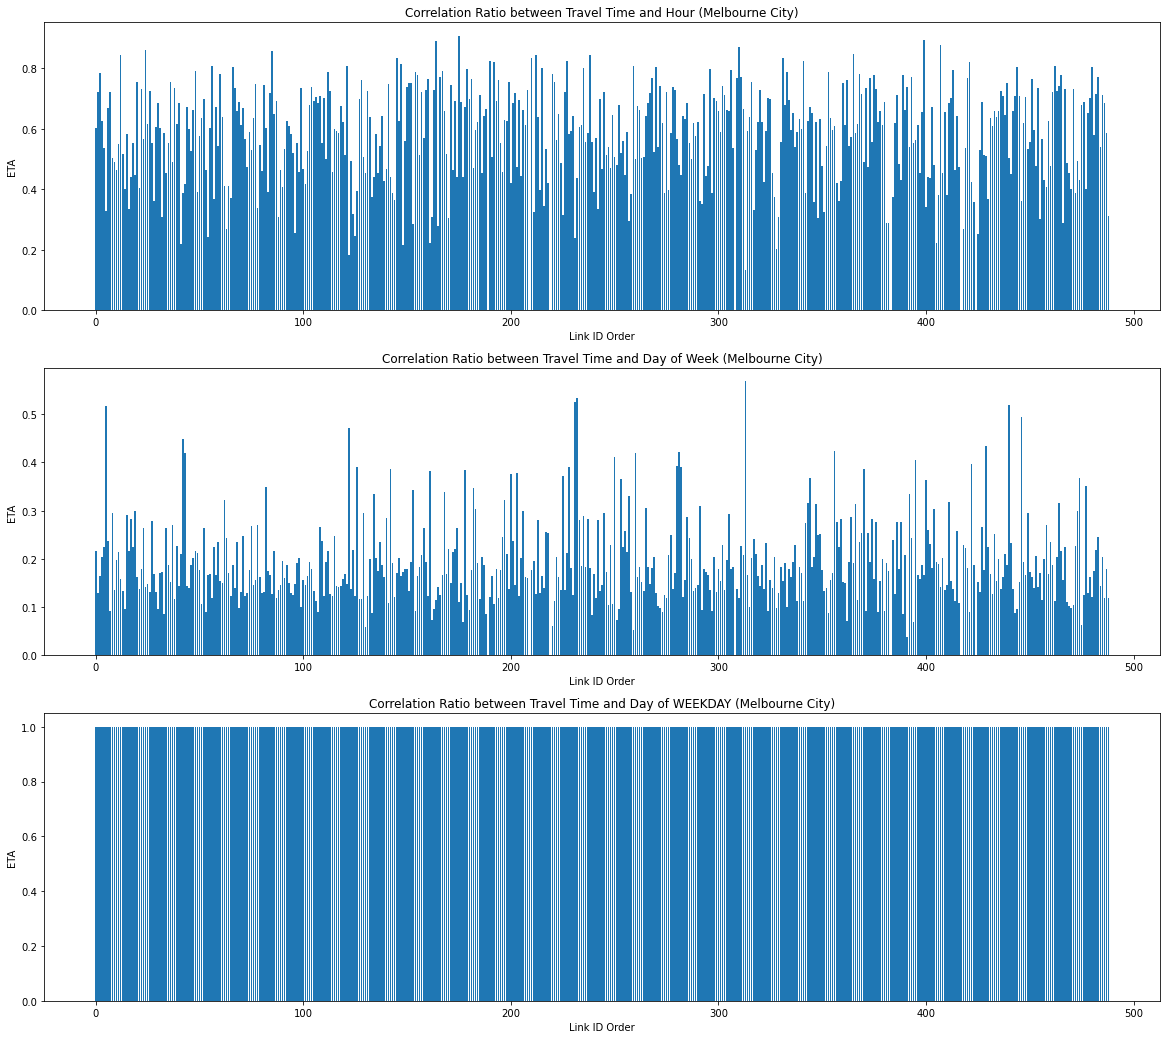

In [13]:
plt.figure(figsize=(20, 18))
plt.subplot(3, 1, 1)
plt.title('Correlation Ratio between Travel Time and Hour (Melbourne City)')
plt.bar(list(range(len(tt_time_corr_ratio))), tt_time_corr_ratio['HOUR_TT_CORR'].values)
# plt.xticks(ticks=list(range(len(tt_time_corr_ratio))), labels=tt_time_corr_ratio['ID'].values)
plt.xlabel('Link ID Order')
plt.ylabel('ETA')

plt.subplot(3, 1, 2)
plt.title('Correlation Ratio between Travel Time and Day of Week (Melbourne City)')
plt.bar(list(range(len(tt_time_corr_ratio))), tt_time_corr_ratio['DAYOFWEEK_TT_CORR'].values)
# plt.xticks(ticks=list(range(len(tt_time_corr_ratio))), labels=tt_time_corr_ratio['ID'].values)
plt.xlabel('Link ID Order')
plt.ylabel('ETA')

plt.subplot(3, 1, 3)
plt.title('Correlation Ratio between Travel Time and Day of WEEKDAY (Melbourne City)')
plt.bar(list(range(len(tt_time_corr_ratio))), tt_time_corr_ratio['WEEKDAY_TT_CORR'].values)
# plt.xticks(ticks=list(range(len(tt_time_corr_ratio))), labels=tt_time_corr_ratio['ID'].values)
plt.xlabel('Link ID Order')
plt.ylabel('ETA')
plt.show()

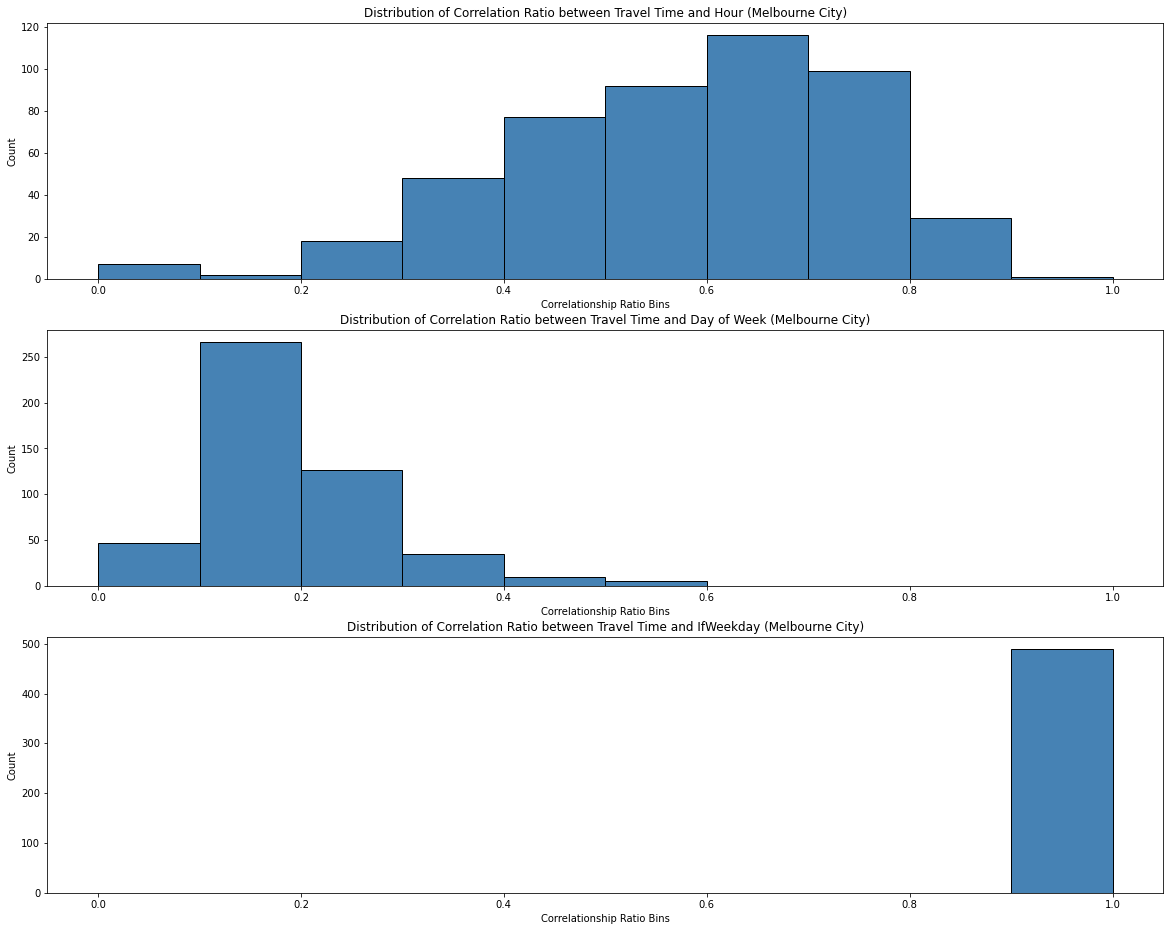

In [14]:
bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

plt.figure(figsize=(20, 16))
plt.subplot(3, 1, 1)
plt.title('Distribution of Correlation Ratio between Travel Time and Hour (Melbourne City)')
plt.hist(tt_time_corr_ratio['HOUR_TT_CORR'].values, bins=bins, color="steelblue", edgecolor="black")

plt.xlabel('Correlationship Ratio Bins')
plt.ylabel('Count')

plt.subplot(3, 1, 2)
plt.title('Distribution of Correlation Ratio between Travel Time and Day of Week (Melbourne City)')
plt.hist(tt_time_corr_ratio['DAYOFWEEK_TT_CORR'].values, bins=bins, color="steelblue", edgecolor="black")
plt.xlabel('Correlationship Ratio Bins')
plt.ylabel('Count')

plt.subplot(3, 1, 3)
plt.title('Distribution of Correlation Ratio between Travel Time and IfWeekday (Melbourne City)')
plt.hist(tt_time_corr_ratio['WEEKDAY_TT_CORR'].values, bins=bins, color="steelblue", edgecolor="black")
plt.xlabel('Correlationship Ratio Bins')
plt.ylabel('Count')

plt.show()


<AxesSubplot:ylabel='Frequency'>

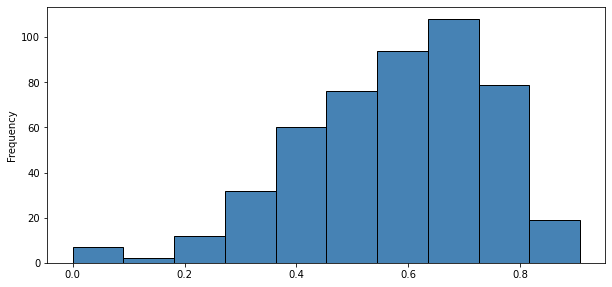

In [15]:
plt.figure(figsize=(10, 16))
plt.subplot(3, 1, 1)
tt_time_corr_ratio['HOUR_TT_CORR'].plot(kind='hist', bins=10, color="steelblue",edgecolor="black")

In [16]:
import os
import geopandas as gpd
import pandas as pd
import folium
import numpy as np
from folium.plugins import TimestampedGeoJson
from sklearn.preprocessing import MinMaxScaler
import scipy.stats as ss
import branca
import matplotlib
import branca.colormap as cm

melb_map = folium.Map(location=[-37.840935, 144.946457], zoom_start=12, tiles='cartodbpositron', fill_opacity=0.001)

DATA_ROOT = os.path.join('../data')
LINK_GDF_PATH = os.path.join(DATA_ROOT, 'link_gdf.geojson')
gdf = gpd.read_file(LINK_GDF_PATH)
corr_ratio_df = tt_time_corr_ratio.copy()
gdf = pd.merge(left=gdf, right=corr_ratio_df, left_on='id', right_on='ID', how='inner')
gdf['color'] = ss.rankdata(gdf[['HOUR_TT_CORR']])
gdf['color'] = gdf['color'].astype('int32')


stats_desc = gdf.describe()['HOUR_TT_CORR']
first_quartile, second_quartile, third_quartile = stats_desc['25%'], stats_desc['50%'], stats_desc['75%']
min_value, max_value = stats_desc['min'], stats_desc['max']

colormap = matplotlib.cm.get_cmap('RdYlGn_r', 5)
color_bar = cm.LinearColormap(colors=[matplotlib.colors.rgb2hex(colormap(i)) for i in range(colormap.N)],
                                    index=[min_value, first_quartile, second_quartile, third_quartile, max_value], 
                                    vmin=min_value, 
                                    vmax=max_value,
                             caption='Correlationship Ratio')


def color_func(feature):
    
    return color_bar(feature['properties']['HOUR_TT_CORR'])

folium.GeoJson(gdf.to_json(),
               name='HOUR_TT_CORR',
               style_function= lambda feature:{'color': color_func(feature), 'weight': 2},
               tooltip=folium.features.GeoJsonTooltip(fields=['id', 'HOUR_TT_CORR'])).add_to(melb_map)

# # gdf['color'] = ss.rankdata(gdf[['DAYOFWEEK_TT_CORR']])
# # color_bar = plt.cm.get_cmap('RdYlGn_r', len(gdf['color'].unique()))

# # folium.GeoJson(gdf.to_json(),
# #                name='DAYOFWEEK_TT_CORR',
# #                style_function= lambda feature:{'color': color_func(feature), 'weight': 2},
# #                tooltip=folium.features.GeoJsonTooltip(fields=['id', 'DAYOFWEEK_TT_CORR'])).add_to(melb_map)

html_title = '<h3 align="center" style="font-size:10px" > <b>Correlation Ratio between Travel Time and Hour (Melbourne City)</b></h3>'
melb_map.get_root().html.add_child(folium.Element(html_title))
melb_map.add_child(color_bar)

melb_map

In [17]:
import os
import geopandas as gpd
import pandas as pd
import folium
import numpy as np
from folium.plugins import TimestampedGeoJson
from sklearn.preprocessing import MinMaxScaler
import scipy.stats as ss
import branca
import matplotlib
import branca.colormap as cm

melb_map = folium.Map(location=[-37.840935, 144.946457], zoom_start=12, tiles='cartodbpositron', fill_opacity=0.001)

DATA_ROOT = os.path.join('../data')
LINK_GDF_PATH = os.path.join(DATA_ROOT, 'link_gdf.geojson')
gdf = gpd.read_file(LINK_GDF_PATH)
corr_ratio_df = tt_time_corr_ratio.copy()
gdf = pd.merge(left=gdf, right=corr_ratio_df, left_on='id', right_on='ID', how='inner')
gdf['color'] = ss.rankdata(gdf[['DAYOFWEEK_TT_CORR']])
gdf['color'] = gdf['color'].astype('int32')


stats_desc = gdf.describe()['DAYOFWEEK_TT_CORR']
first_quartile, second_quartile, third_quartile = stats_desc['25%'], stats_desc['50%'], stats_desc['75%']
min_value, max_value = stats_desc['min'], stats_desc['max']

colormap = matplotlib.cm.get_cmap('RdYlGn_r', 5)
color_bar = cm.LinearColormap(colors=[matplotlib.colors.rgb2hex(colormap(i)) for i in range(colormap.N)],
                                    index=[min_value, first_quartile, second_quartile, third_quartile, max_value], 
                                    vmin=min_value, 
                                    vmax=max_value,
                             caption='Correlationship Ratio')


def color_func(feature):
    
    return color_bar(feature['properties']['DAYOFWEEK_TT_CORR'])

folium.GeoJson(gdf.to_json(),
               name='HOUR_TT_CORR',
               style_function= lambda feature:{'color': color_func(feature), 'weight': 2},
               tooltip=folium.features.GeoJsonTooltip(fields=['id', 'DAYOFWEEK_TT_CORR'])).add_to(melb_map)

html_title = '<h3 align="center" style="font-size:10px" > <b>Correlation Ratio between Travel Time and Day of Week (Melbourne City)</b></h3>'
melb_map.get_root().html.add_child(folium.Element(html_title))
melb_map.add_child(color_bar)

melb_map

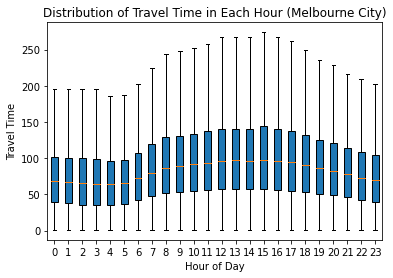

In [18]:
tt = []

for i in range(24):
    tt_each_hour = []
    for link_id in raw_data_df.keys():
        tt_each_hour.extend(raw_data_df[link_id][raw_data_df[link_id]['HOUR'] == i]['TRAVEL_TIME'].to_list())
    tt.append(tt_each_hour)

plt.boxplot(tt, showfliers=False, patch_artist=True)
plt.title('Distribution of Travel Time in Each Hour (Melbourne City)')
plt.xticks([i for i in range(1, 25)], [i for i in range(0, 24)])
plt.xlabel('Hour of Day')
plt.ylabel('Travel Time')
plt.show()

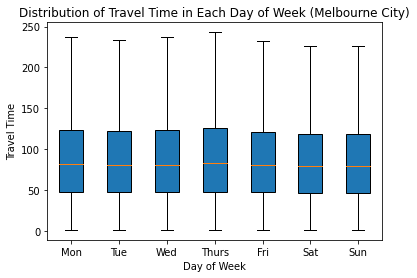

In [19]:
tt = []

for i in range(1, 7):
    tt_each_hour = []
    for link_id in raw_data_df.keys():
        tt_each_hour.extend(raw_data_df[link_id][raw_data_df[link_id]['DAYSOFWEEK'] == i]['TRAVEL_TIME'].to_list())
    tt.append(tt_each_hour)

for link_id in raw_data_df.keys():
    tt_each_hour.extend(raw_data_df[link_id][raw_data_df[link_id]['DAYSOFWEEK'] == 0]['TRAVEL_TIME'].to_list())
tt.append(tt_each_hour)

x_labels = ['Mon', 'Tue', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
plt.boxplot(tt, showfliers=False, patch_artist=True)
plt.title('Distribution of Travel Time in Each Day of Week (Melbourne City)')

plt.xticks([i for i in range(1, 8)], x_labels)
plt.xlabel('Day of Week')
plt.ylabel('Travel Time')
plt.show()

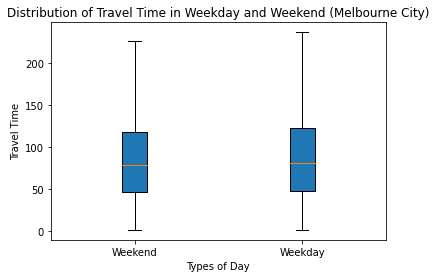

In [20]:
tt = []

for i in range(2):
    tt_each_hour = []
    for link_id in raw_data_df.keys():
        tt_each_hour.extend(raw_data_df[link_id][raw_data_df[link_id]['WEEKDAY'] == i]['TRAVEL_TIME'].to_list())
    tt.append(tt_each_hour)


x_labels = ['Weekend', 'Weekday']
plt.boxplot(tt, showfliers=False, patch_artist=True)
plt.title('Distribution of Travel Time in Weekday and Weekend (Melbourne City)')

plt.xticks([i for i in range(1, 3)], x_labels)
plt.xlabel('Types of Day')
plt.ylabel('Travel Time')
plt.show()

In [21]:
from road_network import RoadNetwork

In [22]:
DATA_ROOT = os.path.join('../data')
LINK_GDF_PATH = os.path.join(DATA_ROOT, 'link_gdf.geojson')
LINK_GEO_PATH = os.path.join(DATA_ROOT, 'GeoLinkData.geojson')
LGA_GEO_PATH = os.path.join(DATA_ROOT, 'LinkLGAData.geojson')
POI_GEO_PATH = os.path.join(DATA_ROOT, 'VicPOIData.geojson')
road_network = RoadNetwork(link_geo_path=LINK_GEO_PATH, lga_geo_path=LGA_GEO_PATH,
                           poi_geo_path=POI_GEO_PATH, processed_link_path=LINK_GDF_PATH)

In [23]:
link_df = road_network.link_gdf
link_df.head(5)

,id,origin,destination,minimum_tt,length,min_number_of_lanes,is_freeway,start_lga,end_lga,poi_num_400m,geometry,poi_num_100m,poi_num_200m,poi_num_300m,poi_num_500m
0,3,2827,686,126,2000,1,False,BOROONDARA CITY,MANNINGHAM CITY,5,"LINESTRING (145.07840 -37.77962, 145.07848 -37...",1,2,2,10
1,5,3357,4187,42,1100,1,False,BANYULE CITY,BANYULE CITY,9,"LINESTRING (145.09357 -37.69418, 145.09332 -37...",2,4,8,14
2,6,4187,3357,30,1100,1,False,BANYULE CITY,BANYULE CITY,11,"LINESTRING (145.08958 -37.70316, 145.08963 -37...",3,3,4,14
3,7,4187,3341,68,1400,1,False,BANYULE CITY,BANYULE CITY,18,"LINESTRING (145.09003 -37.70324, 145.08981 -37...",3,8,14,21
4,8,3341,4187,69,1400,1,False,BANYULE CITY,BANYULE CITY,18,"LINESTRING (145.08263 -37.71442, 145.08276 -37...",4,9,13,20


In [25]:
feature_name = ['id', 'length', 'min_number_of_lanes', 'is_freeway', 'poi_num_100m', 'poi_num_200m', 'poi_num_300m', 'poi_num_400m', 'poi_num_500m']
link_df = road_network.link_gdf[feature_name]
for link_id in raw_data_df.keys():
    raw_data_df[link_id] = raw_data_df[link_id].merge(link_df, left_on='ID', right_on='id')

In [26]:
for distance in BUFFER_DISTANCE:
    stats_desc = research_link_gdf.describe()['poi_num_{}m'.format(distance)]
    first_quartile, second_quartile, third_quartile = stats_desc['25%'], stats_desc['50%'], stats_desc['75%']
    delays = []
    traffic_df_with_poi = pd.merge(traffic_df, research_link_gdf, left_on='ID', right_on='id')
    try:
        traffic_df_with_poi['quartileOfPOI'] = traffic_df_with_poi.apply(lambda x: bin_of_POI(x['poi_num_{}m'.format(distance)], 
                                                                              first_quartile, 
                                                                              second_quartile, 
                                                                              third_quartile), axis=1)
    except:
        print('Cannot add attribute POI Quartile for ', region)

    x_labels = ['<{}'.format(first_quartile), 
                '>={} & <{}'.format(first_quartile, second_quartile), 
                '>={} & <{}'.format(second_quartile, third_quartile),
                '>={}'.format(third_quartile)]

    for i in range(len(x_labels)):
        delays.append(traffic_df_with_poi[traffic_df_with_poi['quartileOfPOI'] == i]['LATEST_ED'].to_list())

        plt.subplot(5, 3, position_flag)
        plt.boxplot(delays, showfliers=False, patch_artist=True)
        plt.title('{} with poi_num_{}m'.format(region, distance))
        plt.xticks([i for i in range(1, 5)], x_labels)
#             plt.ylim(-60, 40)
        plt.xlabel('Bin of POI')
        plt.ylabel('Travel Time')

    position_flag += 1

,ID,TRAVEL_TIME,DENSITY,TIMESTAMP,TIME,HOUR,DAYSOFWEEK,WEEKDAY,id,length,min_number_of_lanes,is_freeway,poi_num_100m,poi_num_200m,poi_num_300m,poi_num_400m,poi_num_500m
0,2727,364,759,1633564800,2021-10-07 11:00:00+11:00,11,3,1,2727,1173,1,False,3,10,20,35,52
1,2727,364,789,1633564830,2021-10-07 11:00:30+11:00,11,3,1,2727,1173,1,False,3,10,20,35,52
2,2727,364,819,1633564860,2021-10-07 11:01:00+11:00,11,3,1,2727,1173,1,False,3,10,20,35,52
3,2727,364,849,1633564890,2021-10-07 11:01:30+11:00,11,3,1,2727,1173,1,False,3,10,20,35,52
4,2727,364,879,1633564920,2021-10-07 11:02:00+11:00,11,3,1,2727,1173,1,False,3,10,20,35,52
